In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path

In [29]:
data_path = Path("../data")
final_df = pd.read_csv("./final_data.csv", sep=",")

In [30]:
final_df

,duration,nr.employed,euribor3m,emp.var.rate,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y
0,0.010471,0.331680,0.712460,0.648092,-0.349494,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,-0.421501,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,-0.124520,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,-0.413787,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.187888,0.331680,0.712460,0.648092,-0.349494,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.292025,-2.815697,-1.495186,-0.752343,-0.349494,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1
41184,0.481012,-2.815697,-1.495186,-0.752343,-0.349494,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
41185,-0.267225,-2.815697,-1.495186,-0.752343,-0.349494,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
41186,0.708569,-2.815697,-1.495186,-0.752343,-0.349494,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1


In [31]:
final_df['y']

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [32]:
X = torch.tensor(final_df.drop("y", axis=1).values, dtype=torch.float32)
y = torch.tensor(final_df["y"].values, dtype=torch.float32)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
# Compute class counts
class_counts = torch.bincount(y_train.int())
class_weights = 1. / class_counts.float()

# Assign weights to each sample based on its class
sample_weights = class_weights[y_train.int()]

In [35]:
X_train.shape

torch.Size([32950, 44])

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
from torch.utils.data import WeightedRandomSampler, DataLoader, TensorDataset

# Create a sampler using the sample weights
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [38]:
# wrap the data in tensordataset
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)

**Training a Neural Network**

In [39]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  
        )

    def forward(self, x):
        return self.model(x)
    
model = BinaryClassifier(input_dim=44)
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [47]:
import matplotlib.pyplot as plt

num_epochs = 10
losses = []  
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 0.1358
Epoch 2/10, Loss: 0.1396
Epoch 3/10, Loss: 0.1353
Epoch 4/10, Loss: 0.1295
Epoch 5/10, Loss: 0.1339
Epoch 6/10, Loss: 0.1347
Epoch 7/10, Loss: 0.1353
Epoch 8/10, Loss: 0.1357
Epoch 9/10, Loss: 0.1311
Epoch 10/10, Loss: 0.1387


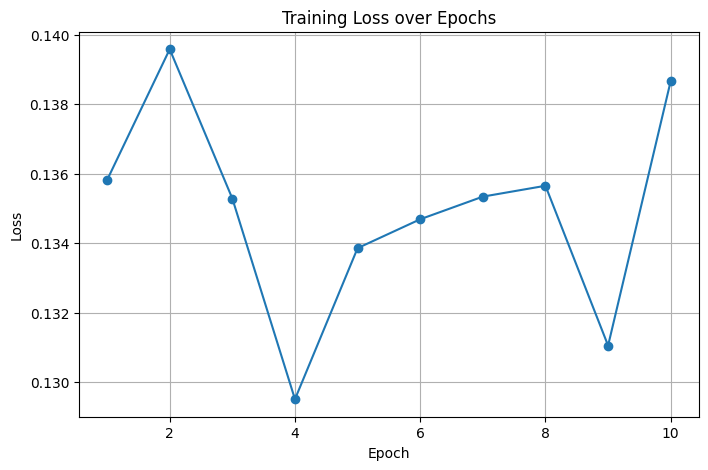

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [50]:
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = torch.sigmoid(model(X).squeeze())
        preds = (outputs > 0.3).float()
        acc = (preds == y).float().mean()
    return acc.item()

accuracy = evaluate(model, X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8701


In [51]:
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.3).int()

        all_preds.extend(preds.view(-1).tolist())
        all_labels.extend(y_batch.view(-1).tolist())

In [52]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8802
Precision: 0.4810
Recall: 0.8050
F1 Score: 0.6022


In [53]:
final_df['y'].value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

**Random Forest**

In [ ]:
X_train_df = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in range(X_train.shape[1])])
y_train_df = pd.Series(y_train, name='y')

# Combine into one DataFrame
train_df = pd.concat([X_train_df, y_train_df], axis=1)

In [62]:
X = final_df.drop("y", axis=1)
y = final_df["y"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.utils import resample
import pandas as pd

# Combine X and y into a single training DataFrame
train_df = pd.concat([X_train, y_train], axis=1)

# Split by class
majority = train_df[train_df.y == 0]
minority = train_df[train_df.y == 1]

# Oversample the minority class
minority_upsampled = resample(
    minority,
    replace=True,                
    n_samples=len(majority),     
    random_state=42
)

# Combine majority and oversampled minority
upsampled_df = pd.concat([majority, minority_upsampled])


In [64]:
X_train_balanced = upsampled_df.drop("y", axis=1)
y_train_balanced = upsampled_df["y"]


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Predict on test set
y_pred = rf.predict(X_test)


In [66]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9079873755765963

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      7310
           1       0.59      0.62      0.60       928

    accuracy                           0.91      8238
   macro avg       0.77      0.78      0.78      8238
weighted avg       0.91      0.91      0.91      8238



In [67]:
import pickle

# Save
with open('../model/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [71]:

# Save the dummy column names
with open('../model/dummy_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)